In [ ]:
import os
import numpy as np
from pathlib import Path
from pzflow.examples import get_galaxy_data
import tables_io
import pandas as pd
import h5py

import rail
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost

In [ ]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

# Set up training and application data

In [ ]:
train_file = 'augmentation_paper_plots/catalogs/shifted_mags/fzboost_color_mag_redshift_upper_limit_augmented_training_catalog.hdf5'
test_file = 'fzboost_hdf5_catalogs/fzboost_application_catalog.hdf5'

training_data = tables_io.read(train_file)
testing_data = tables_io.read(test_file)

training_df = pd.DataFrame(training_data['photometry'])
testing_df = pd.DataFrame(testing_data['photometry'])

training_df.replace(np.inf, 10, inplace=True)

## format data frame for FlexZBoost

In [ ]:
rename_dict = {}
bands = ['u', 'g', 'r', 'i', 'z', 'y']
for band in bands:
    rename_dict[f'{band}'] = 'mag_'+band+'_lsst'
    rename_dict[f'e{band}'] = 'mag_err_'+band+'_lsst'
rename_dict['specz'] = 'redshift'

training_df = training_df.rename(columns=rename_dict)
testing_df = testing_df.rename(columns=rename_dict)

training_df

In [ ]:
headers = ['redshift']
for band in bands:
    headers.append('mag_'+band+'_lsst')
    headers.append('mag_err_'+band+'_lsst')
    
training_df = training_df[headers]
testing_df = testing_df[headers]

training_df

In [ ]:
train_dict = tables_io.convert(training_df, tables_io.types.NUMPY_DICT)
test_dict = tables_io.convert(testing_df, tables_io.types.NUMPY_DICT)

train_data = DS.add_data('train_data', train_dict, TableHandle)
test_data = DS.add_data('test_data', test_dict, TableHandle)

# Train FlexZBoost

In [13]:
fz_dict = dict(zmin=0.0, zmax=3.0, nzbins=301,
               trainfrac=0.75, seed=123, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=35, basis_system='cosine',
               hdf5_groupname='',
               regression_params={'max_depth': 8,'objective':'reg:squarederror'})

In [14]:
inform_fzboost = Inform_FZBoost.make_stage(
    name='inform_FZBoost', 
    model='fzboost_augmented.pkl',
    **fz_dict
)

In [15]:
%%time
inform_fzboost.inform(train_data)

stacking some data...
read in training data
fit the model...
finding best bump thresh...
finding best sharpen parameter...
Inserting handle into data store.  model_inform_FZBoost: inprogress_fzboost_augmented.pkl, inform_FZBoost
CPU times: user 6min 44s, sys: 10.1 s, total: 6min 54s
Wall time: 11min 46s


# Estimate photo-z's for application sample

In [16]:
pzflex_app = FZBoost.make_stage(name='fzboost_app', hdf5_groupname='',
                            model=inform_fzboost.get_handle('model'),
                            )

In [17]:
%%time
fzresults_app = pzflex_app.estimate(test_data)

Process 0 running estimator on chunk 0 - 5520458
Process 0 estimating PZ PDF for rows 0 - 5,520,458
[14:59:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[15:00:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[15:01:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[15:03:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[14:59:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[15:0

## visualize results

In [18]:
speczs_app = test_dict['redshift']
pz_app = fzresults_app().mean().flatten()

In [19]:
#calculate outlier fraction
outlier = np.abs(speczs_app-pz_app)/(1+speczs_app)
out_frac = np.where(outlier > 0.15)
outlier_frac = len(out_frac[0])/len(outlier)
print(outlier_frac)

0.2986630819399405


In [20]:
#calculate NMAD
photz_err = (pz_app-speczs_app)/(1+speczs_app)
med_err = np.median(photz_err)

deviations = np.absolute(photz_err - med_err)

nmad = 1.4826*np.median(deviations)
print(nmad)


0.10555900303554448


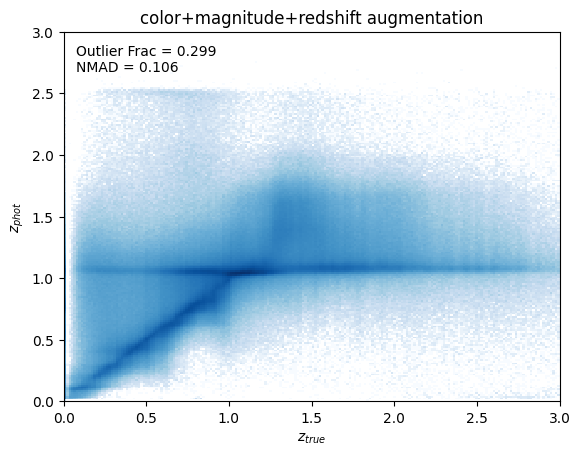

In [22]:
import matplotlib
from matplotlib import pyplot as plt
out_txt = matplotlib.offsetbox.AnchoredText('\n'.join(('Outlier Frac = %.3f' % outlier_frac, 'NMAD = %.3f' % nmad)), frameon=False, loc='upper left')
fig, ax = plt.subplots()
ax.hist2d(speczs_app, pz_app, bins=200, range=[[0, 3], [0,3]], cmap='Blues', cmin=1, norm=matplotlib.colors.LogNorm(), rasterized=True)
ax.set_xlabel(r'$z_{true}$')
ax.set_ylabel(r'$z_{phot}$')
ax.add_artist(out_txt) 
ax.set_title('color+magnitude+redshift augmentation')
           
#plt.savefig('augmentation_paper_plots/mag_shifted_training_samples/FZBoost_color_mag_redshift_w_upper_limit_augmented_training.png')
plt.show()

## Compute zconf and zerr for NNC

In [21]:
modes = fzresults_app().mode(grid=np.linspace(0, 3, 301))
sigmas = fzresults_app().std()

lowlims = modes - sigmas
hilims = modes + sigmas
intquant = fzresults_app().integrate(limits=(lowlims, hilims))

/Users/irenemoskowitz/anaconda3/envs/rail2/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1477: RuntimeWarning: invalid value encountered in sqrt
  res = sqrt(self.stats(*args, **kwds))


In [22]:
zerr = sigmas.flatten()
zconf = intquant.flatten()

In [23]:
outfile = 'augmentation_paper_plots/catalogs/fzboost_application_catalog.hdf5'
outf = h5py.File(outfile, 'r+')
outf.keys()

<KeysViewHDF5 ['color_augmented', 'color_mag_augmented', 'color_mag_redshift_augmented', 'color_redshift_augmented', 'flowed_color_augmented', 'flowed_color_mag_augmented', 'flowed_color_mag_redshift_augmented', 'flowed_color_redshift_augmented', 'flowed_mag_augmented', 'flowed_mag_redshift_augmented', 'flowed_redshift_augmented', 'mag_augmented', 'mag_redshift_augmented', 'photometry', 'redshift_augmented', 'representative', 'shifted_color_augmented', 'shifted_color_mag_augmented', 'shifted_color_mag_redshift_augmented', 'shifted_color_redshift_augmented', 'shifted_mag_augmented', 'shifted_mag_redshift_augmented', 'shifted_redshift_augmented', 'unaugmented']>

In [24]:
group = outf.create_group('magshifted_redshift_augmented')
group['zphot'] = pz_app
group['zerr'] = zerr
group['zconf'] = zconf

In [25]:
outf.close()